In [1]:
pip --version

pip 23.2.1 from /usr/local/lib/python3.11/site-packages/pip (python 3.11)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
########### mflow ############
import mlflow
import mlflow.sklearn
########### mflow ############

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sharelib import *
from report import *

import logging
from pathlib import Path
import json
import glob
import sys
import pickle

import urllib3


logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

jenkinsURL = getArgs(1,"")
mlflowMinioFolder = getArgs(2,"")
mlflowTrainingFileLimit = int(getArgs(13,1))
jenkinsBuildID = getArgs(14,"1")

print("Import Done2.")

2023-12-10 14:35:38.867275: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 14:35:38.978508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 14:35:38.978574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 14:35:38.980641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 14:35:38.994891: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 14:35:38.996494: I tensorflow/core/platform/cpu_feature_guard.cc:1

Import Done2.


In [4]:
if __name__ == "__main__":
    df = pd.DataFrame()
    path_to_json = 'rawdata' 
    json_pattern = os.path.join(path_to_json,'*.txt')
    file_list = glob.glob(json_pattern)
    
    xcount = 0

    for file in file_list:
        xcount = xcount + 1
        print("xcount: ", xcount)
        print(file)
        data = pd.read_json(file, lines=True)
        df = pd.concat([df,data], ignore_index = True)
        if (xcount == mlflowTrainingFileLimit):
            break

xcount:  1
rawdata/ls.s3.534ebdc6-91ec-47c0-a967-d650688894af.2023-11-03T07.55.part264.txt


In [5]:
    np.set_printoptions(threshold=sys.maxsize)
    
    # df_categories = df[df["ads_country_dst"].str.startswith(('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')) == False] 
    df_categories = pd.concat([df["ads_country_dst"]], axis=1, sort=False,)
    print("-------------- Count Record --------------")
    print(df_categories.shape[0])
    print("-------------- Count Record --------------")
    print("-------------- Count Destination Country --------------")
    print(df_categories.value_counts().to_string())
    print("-------------- Count Destination Country --------------")

    countryMap = mapOfCountryDst()
    portMap = mapOfPort()
    print("-------------- Number of Country in Encoding --------------")
    print("country_key : ", len(countryMap.keys()))
    print("country_count : ", len(set(countryMap.values())))
    print("-------------- Number of Country in Encoding --------------")    
    print("-------------- Show Country Not in list --------------")
    print(df_categories[~df_categories['ads_country_dst'].isin(countryMap.keys())].value_counts().to_string())
    print("-------------- Show Country Not in list --------------")

-------------- Count Record --------------
32107
-------------- Count Record --------------
-------------- Count Destination Country --------------
ads_country_dst                 
Thailand                            15281
United States                        6781
Russian Federation                   2810
China                                 923
Japan                                 655
Malaysia                              585
Netherlands                           572
Singapore                             542
United Kingdom                        360
Germany                               334
Sweden                                313
Canada                                279
France                                243
Korea Republic Of                     230
Ukraine                               161
Australia                             159
Brazil                                147
India                                 130
Hong Kong                             122
Iran Islamic Republic

In [6]:
    df_categories = df_categories.mask(~df_categories.isin(countryMap.keys()),'OTHER')
    print("Mask OTHER done")
    X = df_categories.replace({'ads_country_dst': countryMap})
    print("Frequency encoding done")
    print("-------------- Show X --------------")
    print(X)
    print("-------------- Show X --------------")
    # x_scaler = StandardScaler().fit(X)
    # print("Mean of x is:", x_scaler.mean_)
    # print("Variance of x is:", x_scaler.var_)
    # print("Standard deviation of x is:", x_scaler.scale_)
    # x_scaled = x_scaler.transform(X)
    # print(x_scaled)
    print("-------------- Port --------------")
    df_categories = pd.concat([df_categories,df["ads_dst_port"]], axis=1, sort=False,)
    ads_dst_port = pd.concat([df["ads_dst_port"]], axis=1, sort=False,).astype(str)
    ads_dst_port = ads_dst_port.mask(~ads_dst_port.isin(portMap.keys()), 'OTHER')
    ads_dst_port = ads_dst_port.replace({'ads_dst_port': portMap})
    print("-------------- Port --------------")

    X = pd.concat([X,ads_dst_port], axis=1, sort=False,)
    print("-------------- Show X --------------")
    print(type(X))
    print(type(X.to_string()))
    print(X.to_string())    
    print("-------------- Show X --------------")
    
    normalPoint = 30
    mask = (X['ads_country_dst'] <= normalPoint) & (X['ads_dst_port'] == 0)
    X_Test = pd.DataFrame({'test': [-1] * len(df)})
    X_Test.loc[mask, 'test'] = 1

    print("-------------- Show X_Test --------------")
    print(X_Test)
    print("-------------- Show X_Test --------------")
    

Mask OTHER done
Frequency encoding done
-------------- Show X --------------
       ads_country_dst
0                    2
1                    0
2                    0
3                   14
4                    2
...                ...
32102                2
32103                2
32104                2
32105                2
32106                2

[32107 rows x 1 columns]
-------------- Show X --------------
-------------- Port --------------
-------------- Port --------------
-------------- Show X --------------
<class 'pandas.core.frame.DataFrame'>
<class 'str'>
       ads_country_dst  ads_dst_port
0                    2             0
1                    0             0
2                    0             0
3                   14             0
4                    2             0
5                   20             0
6                    0             0
7                    2             0
8                    2             0
9                    2             0
10                

In [7]:
# Call and fit the Local Outlier Factor detector
# lof_detector = LocalOutlierFactor(n_neighbors=30, contamination=0.001,novelty=True).fit(x_scaled)
setNNeighbors = int((df_categories.shape[0]/300))
print("set n_neighbors : " , setNNeighbors)
lof_detector = LocalOutlierFactor(n_neighbors=setNNeighbors, contamination=0.1,novelty=True).fit(X.values)

print("-------------- Model Size (MB) --------------")
print("{:.2f}".format(sys.getsizeof(pickle.dumps(lof_detector))/(1024*1024)))
print("-------------- Model Size (MB) --------------")

# lof_detect = lof_detector.predict(x_scaled)
lof_detect = lof_detector.predict(X)

print(type(lof_detect))
print(lof_detect)

set n_neighbors :  107
-------------- Model Size (MB) --------------
28.05
-------------- Model Size (MB) --------------
<class 'numpy.ndarray'>
[ 1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 

In [8]:
recordDetect,countDetect = np.unique(lof_detect, return_counts=True)
print("--------------Count Anomaly VS Normal-------------")
print(recordDetect)
print(countDetect)

if (len(countDetect) == 1):
    row_to_be_added = countDetect
    countDetect = np.append(np.array([0]),row_to_be_added,axis=0)

print("Anomaly = " , countDetect[0] , "record with " , (countDetect[0])*100/(countDetect[0]+countDetect[1]) ," %")
print("Normal  = " , countDetect[1] , "record with " , (countDetect[1])*100/(countDetect[0]+countDetect[1]) ," %")
print("--------------Count Anomaly VS Normal-------------")

htmlAnomalyVSNormally = '''
<table class="table table-striped">
    <th>Type</th><th class=right-aligned>Record</th><th class=right-aligned>%Record</th>
    <tr><td>Anomaly</td><td class=right-aligned>''' + str(countDetect[0]) + '''</td><td class=right-aligned> ''' + str((countDetect[0])*100/(countDetect[0]+countDetect[1])) + '''</td></tr>
    <tr><td>Normal</td><td class=right-aligned>''' + str(countDetect[1]) + '''</td><td class=right-aligned> ''' + str((countDetect[1])*100/(countDetect[0]+countDetect[1])) + '''</td></tr>
</table>
'''

--------------Count Anomaly VS Normal-------------
[-1  1]
[ 1159 30948]
Anomaly =  1159 record with  3.609804715482605  %
Normal  =  30948 record with  96.39019528451739  %
--------------Count Anomaly VS Normal-------------


In [9]:
print("-------------- List Destination Country Port with Prediction -------------")
# print(type(df_categories.value_counts()))
# print(type(df_categories))

htmlItem = ""

for index, value in df_categories.value_counts().items():
    encode = countryMap[index[0]]

    portEncode = 0
    if (str(index[1]) in portMap):
        portEncode = portMap[str(index[1])]

    predictData = lof_detector.predict([[ encode , portEncode ]])

    if (portEncode > 0):
        print(index[0]  , " | code =" , encode , " | Port Level = ", index[1] , "/" , str(portEncode)  , " | count ="  , value , " | result =" , dataPredictionToString(predictData[0]))
    
    htmlItem = htmlItem + "<tr><td>" + index[0] + "</td><td class=right-aligned>" + str(encode) + "</td><td class=right-aligned>" + str(index[1]) + "</td><td class=right-aligned>" + str(portEncode) + "</td><td class=right-aligned>" + str(value)+ "</td><td>" + dataPredictionToString(predictData[0]) + "</td><tr>"
print("-------------- List Destination Country with Prediction -------------")

htmlCountryPrediction = '''
<table class="table table-striped">
    <th>Country</th><th class=right-aligned>CODE</th><th class=right-aligned>Port</th><th class=right-aligned>Malware DST Ports Level</th><th class=right-aligned>Amount</th><th>Prediction</th>
    ''' + htmlItem + '''
</table>
'''

-------------- List Destination Country Port with Prediction -------------
Thailand  | code = 2  | Port Level =  9001 / 9001  | count = 4  | result = Anomaly
Thailand  | code = 2  | Port Level =  4443 / 4443  | count = 2  | result = Anomaly
Germany  | code = 17  | Port Level =  4443 / 4443  | count = 2  | result = Anomaly
United States  | code = 0  | Port Level =  1166 / 1166  | count = 1  | result = Anomaly
Thailand  | code = 2  | Port Level =  49181 / 49181  | count = 1  | result = Anomaly
Thailand  | code = 2  | Port Level =  7777 / 7777  | count = 1  | result = Anomaly
Thailand  | code = 2  | Port Level =  8899 / 8899  | count = 1  | result = Anomaly
Singapore  | code = 6  | Port Level =  1337 / 1337  | count = 1  | result = Anomaly
Thailand  | code = 2  | Port Level =  666 / 666  | count = 1  | result = Anomaly
Thailand  | code = 2  | Port Level =  81 / 81  | count = 1  | result = Anomaly
Thailand  | code = 2  | Port Level =  1990 / 1990  | count = 1  | result = Anomaly
Thailand  

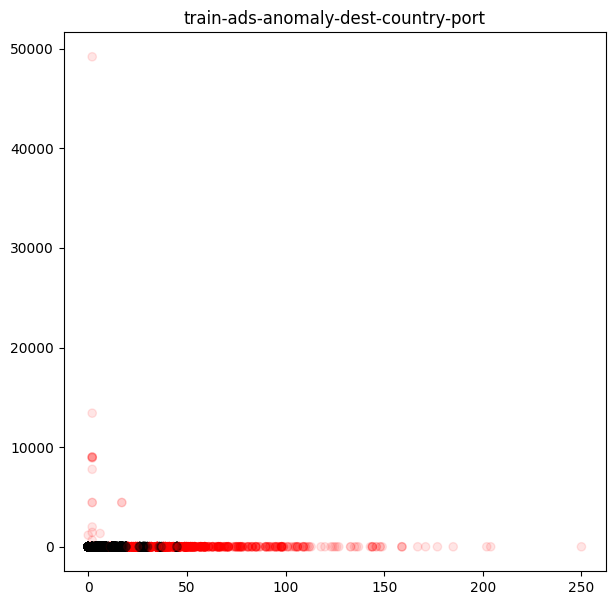

In [10]:
plt.figure(figsize=(7,7))
# plt.scatter(x_scaled[:, 0], x_scaled[:, 0], c=lof_detect, cmap="flag", alpha=0.5)
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=lof_detect, cmap="flag", alpha=0.1)
plt.title("train-ads-anomaly-dest-country-port")
plt.savefig('images/train-ads-anomaly-dest-country-port.png')
plt.show()

In [11]:
print("-------------- Machine Learning - Confusion Matrix -------------")
Accuracy = metrics.accuracy_score(X_Test, lof_detect)
print("Accuracy : " , Accuracy)
Precision = metrics.precision_score(X_Test, lof_detect)
print("Precision : " , Precision)
Sensitivity_recall = metrics.recall_score(X_Test, lof_detect)
print("Sensitivity_recall : " , Sensitivity_recall)
Specificity = metrics.recall_score(X_Test, lof_detect, pos_label=-1)
print("Specificity : " , Specificity)
F1_score = metrics.f1_score(X_Test, lof_detect)
print("F1_score : " , F1_score)
print("-------------- Machine Learning - Confusion Matrix -------------")

htmlMatrix = '''
<table class="table table-striped">
    <th>Type</th><th>Meaning</th><th class=right-aligned>Score</th>
    <tr><td>Accuracy</td><td>The proportion of correctly predicted cases</td><td class=right-aligned>''' + str(Accuracy) + '''</td></tr>
    <tr><td>Precision</td><td>Positive Predictive Value</td><td class=right-aligned>''' + str(Precision) + '''</td></tr>
    <tr><td>Sensitivity_recall</td><td> True Positive Rate</td><td class=right-aligned>''' + str(Sensitivity_recall) + '''</td></tr>
    <tr><td>Specificity</td><td>True Negative Rate</td><td class=right-aligned>''' + str(Specificity) + '''</td></tr>
    <tr><td>F1_score</td><td>Balances precision and recall</td><td class=right-aligned>''' + str(F1_score) + '''</td></tr>    
</table>
'''

-------------- Machine Learning - Confusion Matrix -------------
Accuracy :  0.9818419659264335
Precision :  0.9926328034121753
Sensitivity_recall :  0.9885760257441674
Specificity :  0.7790697674418605
F1_score :  0.9906002611934283
-------------- Machine Learning - Confusion Matrix -------------


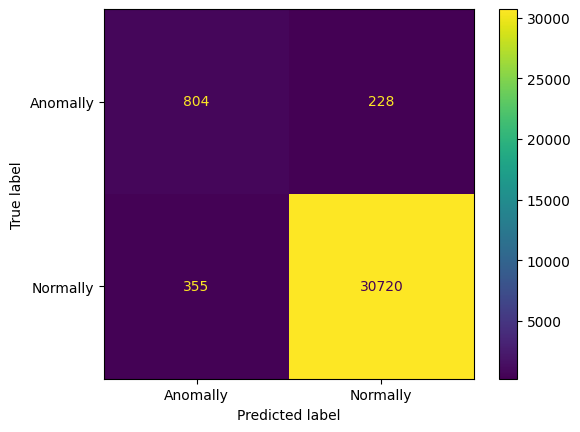

In [12]:
confusion_matrix = metrics.confusion_matrix(X_Test, lof_detect)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anomally", "Normally"])
cm_display.plot()
plt.savefig('images/train-ads-anomaly-dest-country-port-confusion-matrix.png')
plt.show()

In [13]:
summary_table = '''
<p>Count Record : ''' + str(df_categories.shape[0]) + '''</p>
<h2>Local Outlier Factor (LOF)</h2>
<p>n_neighbors : ''' + str(setNNeighbors) + '''</p>
''' + htmlAnomalyVSNormally + '''
''' + htmlCountryPrediction + '''
<table class="table table-striped">
<th>Local Outlier Factor (LOF)</th>
<tr>
    <td><img src="train-ads-anomaly-dest-country-port-port.png" alt="train-ads-anomaly-dest-country-port.png"></td>
</tr>
    </table>
<table class="table table-striped">
<th>confusion-matrix</th>
<tr>
    <td><img src="train-ads-anomaly-dest-country-port-confusion-matrix.png" alt="confusion-matrix"></td>
</tr>
</table>
''' + htmlMatrix + '''
'''

In [14]:
html_string = mainReportHTML("train-ads-anomaly-dest-country-port",summary_table)
f = open('report.html','w')
f.write(html_string)
f.close()

In [15]:
df_target = pd.DataFrame(lof_detect, columns=['threat'])
print(df_target.to_string())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df_target, test_size=0.2)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train.values)
scaled_X_test = scaler.transform(X_test.values)

       threat
0           1
1           1
2           1
3           1
4           1
5          -1
6           1
7           1
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1
16          1
17          1
18          1
19          1
20          1
21          1
22          1
23          1
24          1
25          1
26          1
27          1
28          1
29          1
30          1
31          1
32          1
33          1
34          1
35          1
36          1
37          1
38          1
39          1
40         -1
41          1
42         -1
43          1
44          1
45          1
46          1
47          1
48          1
49          1
50          1
51          1
52          1
53          1
54          1
55          1
56          1
57         -1
58          1
59          1
60          1
61          1
62          1
63          1
64          1
65          1
66          1
67          1
68          1
69          1
70    

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(scaled_X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
803/803 [==============================] - 5s 4ms/step - loss: 0.4344 - accuracy: 0.8376
Epoch 2/10
803/803 [==============================] - 1s 2ms/step - loss: 0.2110 - accuracy: 0.9178
Epoch 3/10
803/803 [==============================] - 2s 2ms/step - loss: 0.0921 - accuracy: 0.9295
Epoch 4/10
803/803 [==============================] - 1s 2ms/step - loss: 0.0197 - accuracy: 0.9361
Epoch 5/10
803/803 [==============================] - 1s 2ms/step - loss: -0.0304 - accuracy: 0.9361
Epoch 6/10
803/803 [==============================] - 1s 2ms/step - loss: -0.0692 - accuracy: 0.9361
Epoch 7/10
803/803 [==============================] - 1s 2ms/step - loss: -0.1013 - accuracy: 0.9361
Epoch 8/10
803/803 [==============================] - 1s 2ms/step - loss: -0.1296 - accuracy: 0.9361
Epoch 9/10
803/803 [==============================] - 1s 2ms/step - loss: -0.1556 - accuracy: 0.9361
Epoch 10/10
803/803 [==============================] - 2s 2ms/step - loss: -0.1799 - accuracy: 

In [17]:
loss, accuracy = model.evaluate(scaled_X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

201/201 [==============================] - 1s 2ms/step - loss: -0.1741 - accuracy: 0.9393
Loss: -0.17413204908370972
Accuracy: 0.9392712712287903


In [18]:
predictions = model.predict(scaled_X_test)
threshold = 0.5
class_predictions = [1 if p >= threshold else -1 for p in predictions]
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, class_predictions)
print(f'Accuracy: {accuracy}')


201/201 [==============================] - 0s 1ms/step
Accuracy: 0.9691684833385238


In [19]:
x_new = np.array([[1, 0],[2, 4433]])  # replace with your actual data

new_data_scaled = scaler.transform(x_new)  # Assuming 'scaler' is your StandardScaler object
y_new = model.predict(new_data_scaled)

print(y_new)

new_arr = np.where(y_new >= 0.5, 1, -1)

print(new_arr)

1/1 [==============================] - 0s 32ms/step
[[9.9593431e-01]
 [6.2227923e-06]]
[[ 1]
 [-1]]


In [20]:
%set_env MLFLOW_TRACKING_URI=http://mlflow.rtarf-ml.its-software-services.com/
tracking_uri = os.environ["MLFLOW_TRACKING_URI"]
%set_env MLFLOW_TRACKING_USERNAME=admin 
%set_env MLFLOW_TRACKING_PASSWORD=<PASSWORD>

experiment = mlflow.set_experiment(experiment_name='ads-tensorflow-supervised-dest-country-port')
experiment_id = experiment.experiment_id

reportURL = "https://minio-api.rtarf-ml.its-software-services.com/ml-report/ads-tensorflow-supervised-dest-country-port/" + jenkinsBuildID + "/report.html"

run_description = f"""
### Note
**All information** * about Training * ~~ML here~~
Jenkins URL: [{jenkinsURL}]({jenkinsURL})
Report: [{reportURL}]({reportURL})
"""

with mlflow.start_run(experiment_id=experiment_id,description=run_description):
    mlflow.set_tracking_uri(tracking_uri)
    
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("artifact uri : " + mlflow.get_artifact_uri())

    mlflow.environment_variables.MLFLOW_ARTIFACT_UPLOAD_DOWNLOAD_TIMEOUT="5000"

    mlflow.doctor()
    mlflow.log_param("MlflowMinioFolder", mlflowMinioFolder)
    mlflow.log_param("country_key", len(countryMap.keys()))
    mlflow.log_param("country_count", len(set(countryMap.values())))

    mlflow.log_param("SampleFile", xcount)
    mlflow.log_param("SampleRows", X.shape[0])
    # mlflow.set_tag("JenkinsURL",jenkinsURL)

    mlflow.log_metric("Anomaly", str((countDetect[0])*100/(countDetect[0]+countDetect[1])))
    mlflow.log_metric("Normal", str((countDetect[1])*100/(countDetect[0]+countDetect[1])))
    mlflow.sklearn.log_model(model, "model", registered_model_name="ads-tensorflow-supervised-dest-country-port")
    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)


print("-------------- Model save success -------------")

env: MLFLOW_TRACKING_URI=http://mlflow.rtarf-ml.its-software-services.com/
env: MLFLOW_TRACKING_USERNAME=admin
env: MLFLOW_TRACKING_PASSWORD=LGs%YyqhfYxv
Artifact Location: mlflow-artifacts:/4
artifact uri : mlflow-artifacts:/4/1cf6221442d842b3b51d395d4d8c117e/artifacts
System information: Linux #99-Ubuntu SMP Mon Oct 30 20:42:41 UTC 2023
Python version: 3.11.5
MLflow version: 2.1.1
MLflow module location: /home/jovyan/.local/lib/python3.11/site-packages/mlflow/__init__.py
Tracking URI: http://mlflow.rtarf-ml.its-software-services.com/
Registry URI: http://mlflow.rtarf-ml.its-software-services.com/
Active experiment ID: 4
Active run ID: 1cf6221442d842b3b51d395d4d8c117e
Active run artifact URI: mlflow-artifacts:/4/1cf6221442d842b3b51d395d4d8c117e/artifacts
MLflow environment variables: 
  MLFLOW_TRACKING_PASSWORD: LGs%YyqhfYxv
  MLFLOW_TRACKING_URI: http://mlflow.rtarf-ml.its-software-services.com/
  MLFLOW_TRACKING_USERNAME: admin
MLflow dependencies: 
  Flask: 2.3.3
  Jinja2: 3.1.2
  

/usr/local/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'ads-tensorflow-supervised-dest-country-port' already exists. Creating a new version of this model...
2023/12/10 14:37:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ads-tensorflow-supervised-dest-country-port, version 2


Model saved in run 1cf6221442d842b3b51d395d4d8c117e
-------------- Model save success -------------


Created version '2' of model 'ads-tensorflow-supervised-dest-country-port'.
